In [39]:
################## IMPORT LIBRARIES ##################
import soundfile as sf
from IPython.display import Audio
import numpy as np
import sys
import importlib
import random 
import pandas as pd
pd.options.mode.copy_on_write = True
import time
from os.path import join as pjoin
from acoustics.bands import third
import scipy.signal as sig
from IPython.display import Audio
# from masp import shoebox_room_sim as srs
from scipy.io import wavfile
#import mat73
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (4, 3)
import torch 

In [40]:
################## IMPORT MY MODULES ##################
sys.path.append('../src')

import helpers as hlp
import evaluation
import dataset as ds
import trainer
import models

importlib.reload(evaluation)
importlib.reload(hlp)
importlib.reload(ds)
importlib.reload(trainer)
importlib.reload(models)

<module 'models' from '/home/ubuntu/joanna/reverb-match-cond-u-net/notebooks/../src/models.py'>

In [44]:
################## LOAD TRAINING RESULTS AND CONFIG  ##################

datapath="/home/ubuntu/Data/RESULTS-reverb-match-cond-u-net/"
exp_tag="runs-exp-28-03-2024"
train_tag="02-04-2024--14-14_many-to-many_stft_1"

config ,train_results = trainer.load_train_results(datapath, exp_tag, train_tag,configtype="pt")


In [46]:
config["n_blocks_revenc"]

8

In [47]:
################## LOAD DATASET AND CHECK 1 DATAPOINT SAMPLE  ##################

# instantiate a test data set 
config["split"]="test"
config["df_metadata"]="/home/ubuntu/joanna/reverb-match-cond-u-net/dataset-metadata/nonoise_48khz_guestxr.csv"
config["p_noise"]=0
dataset=ds.DatasetReverbTransfer(config)
# get one data sample 
sContent, sStyle, sTarget, sAnecho = dataset[2]

# playback for the data sample
audios=[sContent, sStyle, sTarget]
names=["sContent", "sStyle", "sTarget"]

for i,audio in enumerate(audios):
    print(names[i])
    audio=audio.squeeze(0).cpu()
    display(Audio(audio,rate=48e3))


sContent


sStyle


sTarget


In [48]:
################## LOAD MODELS AND TRAINING WEIGHTS  ##################

model=trainer.load_chosen_model(config,config["modeltype"])

model.autoencoder.load_state_dict(train_results["model_waveunet_state_dict"])
model.conditioning_network.load_state_dict(train_results["model_reverbenc_state_dict"])

<All keys matched successfully>

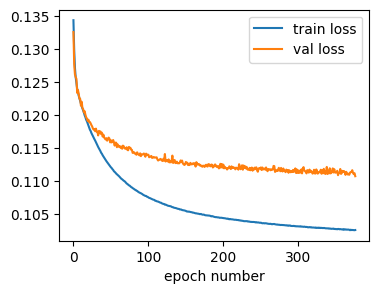

In [49]:
################## PLOT TRAINING LOSS EVOLUTION  ##################

# load and plot the loss evolution 
loss = list(zip(*train_results['loss']))
plt.figure()
plt.plot(loss[0],label="train loss")
plt.plot(loss[1],label="val loss")
plt.xlabel("epoch number")
plt.legend()
plt.show()

In [50]:
################## SEARCH FOR DATA POINTS FROM TEST SET WITH SPECIFIC PROPERTIES   ##################

# choose indices from a data set with specified difference
chosen_rt60_idx_list=dataset.get_idx_with_rt60diff(-0.9,-0.85)
# chosen_rt60_idx_list=dataset.get_idx_with_rt60diff(0.85,0.9)


In [51]:
################## INFERENCE FOR ONE DATA SAMPLE  ##################

dp=chosen_rt60_idx_list[random.randint(0, len(chosen_rt60_idx_list) - 1)]
sContent,sStyle,sTarget,sPrediction=trainer.infer(model,dataset[dp],config["device"])
if bool(config["is_vae"]):
    sPrediction, _, _ = sPrediction

sContent:


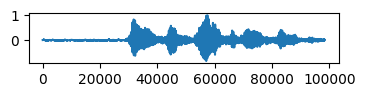

sStyle:


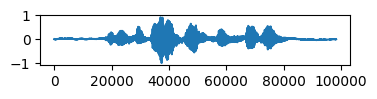

sTarget:


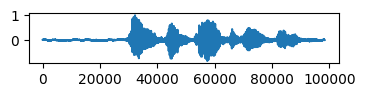

sPrediction:


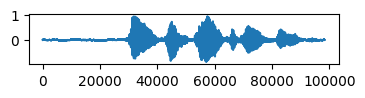

In [52]:
################## PLOT AND PLAY BACK CONTENT, STYLE, TARGET AND PREDICTION ##################

audios=[sContent, sStyle, sTarget, sPrediction]
names=["sContent", "sStyle", "sTarget", "sPrediction"]

plt.figure()
for i,audio in enumerate(audios):
    print(names[i]+":")
    plt.subplot(4,1,i+1)
    audio=audio.squeeze(0).cpu()
    if i==3:
        audio=audio.squeeze(0)
    # wavfile.write("sounds/dp_"+str(dp)+"_"+names[i]+".wav", int(48e3), audio.numpy())
    plt.plot(audio)
    plt.show()
    display(Audio(audio,rate=48e3))

In [53]:
################## GENERATE EMBEDDING ARRAY AND PARAMETER ARRAYS FROM MULTIPLE DATA POINTS ##################

emb_arr=np.zeros([len(dataset),512])
rt30_meas_arr=np.zeros([len(dataset),1])
edt_meas_arr=np.zeros([len(dataset),1])
c50_meas_arr=np.zeros([len(dataset),1])
rt60_set_arr=np.zeros([len(dataset),1])
rt60_true_arr=np.zeros([len(dataset),1])
for j,data in enumerate(dataset):
    # get style audio
    sStyle_in=data[1]
    # get style info
    df_Style=dataset.get_info(j,id="style")
    # get style embedding of size 512
    with torch.no_grad():
        embedding=model.conditioning_network(sStyle_in.unsqueeze(0).to(config["device"]))
        emb_arr[j,:]=embedding.cpu().numpy()
    rt30_meas_arr[j]=df_Style["rt30_meas"]
    rt60_set_arr[j]=df_Style["rt60_set"]
    rt60_true_arr[j]=df_Style["rt60_true"]
    edt_meas_arr[j]=df_Style["edt_meas"]
    c50_meas_arr[j]=df_Style["c50_meas"]
    if j==1000:
        break


In [56]:
################## PERFORM DIMENSIONALITY REDUCTION ON THE EMBEDDING SPACE ##################

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

indices_subset=range(1000)
# reduce dimensionality of the embeddings
# using pca:
embeddings_pca=PCA(n_components=2).fit_transform(emb_arr[indices_subset,:])
# using first pca and then tsne:
embeddings_pca_tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=20).fit_transform(PCA(n_components=20).fit_transform(emb_arr[indices_subset,:]))
# using tsne:
embeddings_tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=20).fit_transform(emb_arr[indices_subset,:])

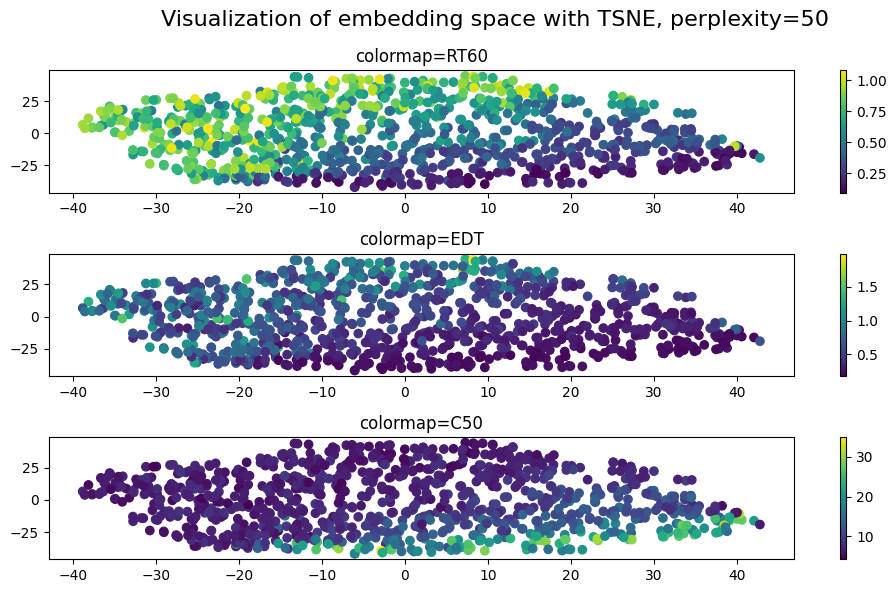

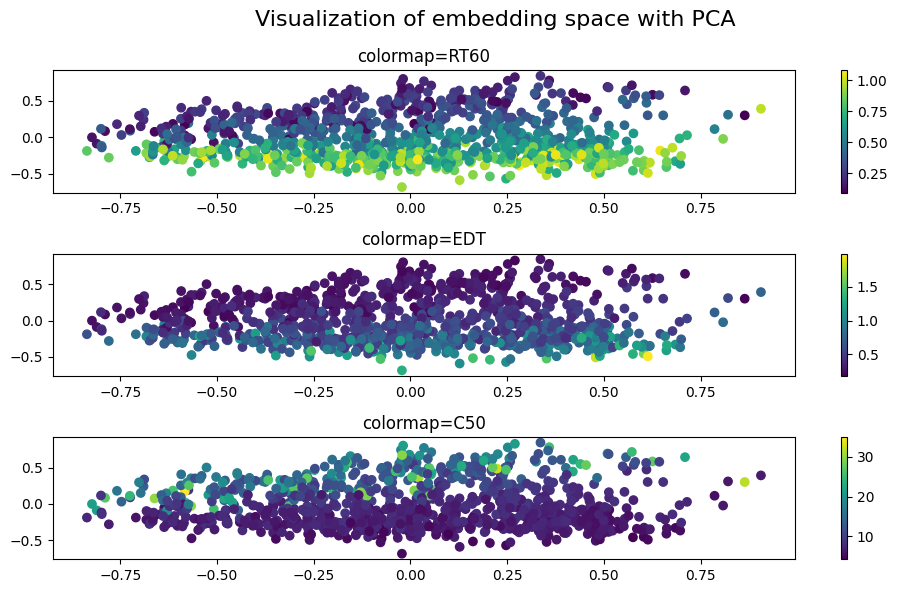

In [57]:
################## PLOT TSNE 2-DIM VISUALISATION OF THE EMBEDDING SPACE ##################

# plt.figure(figsize=(10,6))
# plt.suptitle('Visualization of embeddings with TSNE, perplexity=50', fontsize=16)
# plt.subplot(2,3,1)
# plt.scatter(embeddings_tsne[:,0] , embeddings_tsne[:,1], c=rt30_meas_arr[indices_subset]);plt.colorbar();plt.title('colormap=rt30 meas')
# plt.subplot(2,3,2)
# plt.scatter(embeddings_tsne[:,0] , embeddings_tsne[:,1], c=rt60_true_arr[indices_subset]);plt.colorbar();plt.title('colormap=rt60 meas')
# plt.subplot(2,3,3)
# plt.scatter(embeddings_tsne[:,0] , embeddings_tsne[:,1], c=rt60_set_arr[indices_subset]);plt.colorbar();plt.title('colormap=rt60 set')
# plt.subplot(2,3,4)
# plt.scatter(embeddings_tsne[:,0] , embeddings_tsne[:,1], c=edt_meas_arr[indices_subset]);plt.colorbar();plt.title('colormap=edt')
# plt.subplot(2,3,5)
# plt.scatter(embeddings_tsne[:,0] , embeddings_tsne[:,1], c=c50_meas_arr[indices_subset]);plt.colorbar();plt.title('colormap=c50')
# cmap = plt.get_cmap('cool')
# plt.set_cmap(cmap)


plt.figure(figsize=(10,6))
plt.suptitle('Visualization of embedding space with TSNE, perplexity=50', fontsize=16)
plt.subplot(3,1,1)
plt.scatter(embeddings_tsne[:,0] , embeddings_tsne[:,1], c=rt60_true_arr[indices_subset]);plt.colorbar();plt.title('colormap=RT60')
plt.subplot(3,1,2)
plt.scatter(embeddings_tsne[:,0] , embeddings_tsne[:,1], c=edt_meas_arr[indices_subset]);plt.colorbar();plt.title('colormap=EDT')
plt.subplot(3,1,3)
plt.scatter(embeddings_tsne[:,0] , embeddings_tsne[:,1], c=c50_meas_arr[indices_subset]);plt.colorbar();plt.title('colormap=C50')

plt.tight_layout()
plt.show()


plt.figure(figsize=(10,6))
plt.suptitle('Visualization of embedding space with PCA', fontsize=16)
plt.subplot(3,1,1)
plt.scatter(embeddings_pca[:,0] , embeddings_pca[:,1], c=rt60_true_arr[indices_subset]);plt.colorbar();plt.title('colormap=RT60')
plt.subplot(3,1,2)
plt.scatter(embeddings_pca[:,0] , embeddings_pca[:,1], c=edt_meas_arr[indices_subset]);plt.colorbar();plt.title('colormap=EDT')
plt.subplot(3,1,3)
plt.scatter(embeddings_pca[:,0] , embeddings_pca[:,1], c=c50_meas_arr[indices_subset]);plt.colorbar();plt.title('colormap=C50')

plt.tight_layout()
plt.show()

In [61]:
################## GENERATE EMBEDDING ARRAY AND PARAMETER ARRAYS FROM MULTIPLE DATA POINTS ##################


from torch.utils.data import Subset

# Create a special data set containing style data with only one specific impulse response
N_audios=100
N_irs=5
emb_arr=np.zeros([N_audios*N_irs,512])
id_array=np.zeros([N_audios*N_irs,1])


styleIR_indices=list(range(0, N_irs))
for i,idx in enumerate(styleIR_indices):
    config["split"]="test"
    config["style_rir"]=dataset.get_info(idx)["ir_file_path"]
    print(config["style_rir"])
    dataset_this_ir=ds.DatasetReverbTransfer(config)
    indices_audios=list(range(0,N_audios))
    dataset_this_ir=Subset(dataset_this_ir,indices_audios)

    for j,data in enumerate(dataset_this_ir):
        # get style audio
        sStyle_in=data[1]
        # get style embedding of size 512
        with torch.no_grad():
            embedding=model.conditioning_network(sStyle_in.unsqueeze(0).to(config["device"]))
            emb_arr[(i*N_audios)+j,:]=embedding.cpu().numpy()
        id_array[(i*N_audios)+j]=i



/home/ubuntu/Data/synth_rirs_mono/monoRIR_x694y425z346_rtms22.wav
/home/ubuntu/Data/synth_rirs_mono/monoRIR_x1494y1307z254_rtms44.wav
/home/ubuntu/Data/synth_rirs_mono/monoRIR_x836y507z449_rtms26.wav
/home/ubuntu/Data/synth_rirs_mono/monoRIR_x1057y723z393_rtms34.wav
/home/ubuntu/Data/synth_rirs_mono/monoRIR_x2387y1875z393_rtms77.wav


In [62]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# reduce dimensionality of the embeddings
# using pca:
embeddings_pca=PCA(n_components=2).fit_transform(emb_arr)
# using first pca and then tsne:
embeddings_pca_tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=10).fit_transform(PCA(n_components=50).fit_transform(emb_arr))
# using tsne:
embeddings_tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=10).fit_transform(emb_arr)

ValueError: n_components=50 must be between 0 and min(n_samples, n_features)=10 with svd_solver='full'

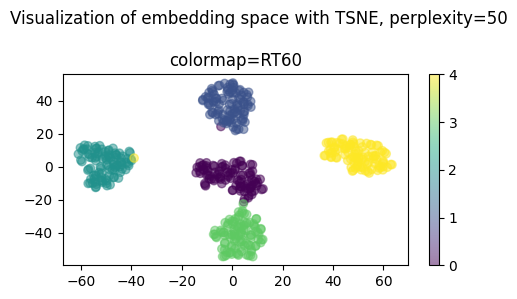

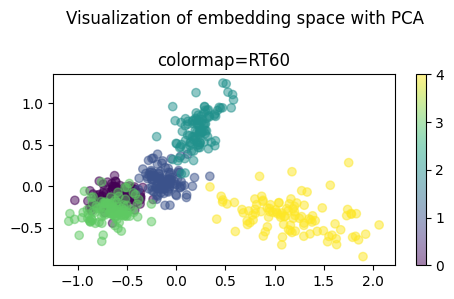

In [ ]:

plt.figure(figsize=(5,3))
plt.suptitle('Visualization of embedding space with TSNE, perplexity=50', fontsize=12)
plt.scatter(embeddings_tsne[:,0] , embeddings_tsne[:,1], c=id_array,alpha=0.5);plt.colorbar();plt.title('colormap=RT60')
plt.tight_layout()
plt.show()

plt.figure(figsize=(5,3))
plt.suptitle('Visualization of embedding space with PCA', fontsize=12)
plt.scatter(embeddings_pca[:,0] , embeddings_pca[:,1], c=id_array, alpha=0.5);plt.colorbar();plt.title('colormap=RT60')
plt.tight_layout()
plt.show()




